# Tank Filling Route Optimization with Reinforcement Learning

## Description of Problem

The travelling salesman problem (TSP) is a classic algorithmic problem in the field of computer science and operations research. Given a list of cities and the distances between each pair of cities, the problem is to find the most efficien t possible route that visits each city and returns to the origin city.

In the classic version of the problem, the salesman picks a city to start, travels through remaining cities and returns to the original city. 

In this version, we have slightly modified the problem, presenting it as a tank filling delivery problem on a 2D gridworld.  The agent (driver) starts at the chemical depot, a fixed point on the grid.  Then, the tanks appear elsewhere on the grid.  The driver needs to visit the the tanks to obtain rewards.  Rewards are proportional to the time taken to do this (equivalent to the distance, as each timestep moves one square on the grid).

## Easy Version
In the Easy Version, we are on a very small grid.  All tank locations are generated at the start of the episode.  Tank locations are fixed, and are invariant (non-random) from episode to episode.  The objective is to visit each tank location, and return to the depot.  We have a maximum time-limit of 50 steps.  

### States
At each time step, our agent is aware of the following information:

1. For the Chemical Depot:
    1. Location (x,y coordinates)
    
2. For the Driver
    1. Location (x,y coordinates)
    2. Is driver at depot (yes/no)

3. For each Tank: 
    1. Location (x,y coordinates)
    2. Status (Delivered or Not Delivered)
    3. Time (Time taken to deliver reach tank -- incrementing until delivered)
4. Miscellaneous
    1. Time since start of episode
    2. Time remaining until end of episode (i.e. until max time)

### Actions
At each time step, our agent can take the following steps:
- Up - Move one step up in the map
- Down - Move one step down in the map
- Right - Move one step right in the map
- Left - Move one step left in the map

### Rewards
Agent gets a reward of -1 for each time step. If an tank is visited in that timestep, it gets a positive reward inversely proportional to the time taken to deliver. If all the tanks are visited and the agent is back to the depot, it gets an additional reward inversely proportional to time since start of episode. 


## Using AWS SageMaker for RL

AWS SageMaker allows you to train your RL agents in cloud machines using docker containers. You do not have to worry about setting up your machines with the RL toolkits and deep learning frameworks. You can easily switch between many different machines setup for you, including powerful GPU machines that give a big speedup. You can also choose to use multiple machines in a cluster to further speedup training, often necessary for production level loads.

### Prerequisites 

#### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [1]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

In [2]:
!pip install gym
!pip install pygame

    100% |████████████████████████████████| 1.6MB 16.6MB/s ta 0:00:01
    100% |████████████████████████████████| 1.0MB 20.4MB/s ta 0:00:01
    100% |████████████████████████████████| 829kB 24.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for gym ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/00/b8/b2/e5dfb6be621560717e719734293eee9fe3c66b668fdc334b1a
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built gym future
  Found existing installation: cloudpickle 0.5.3
    Uninstalling cloudpickle-0.5.3:
      Successfully uninstalled cloudpickle-0.5.3
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 11.4MB 4.3MB/s eta 0:00:01    92% |█████████████████████████████▋  | 10.6MB 38.7MB/s eta 0:00:01
You are 

In [3]:
env_type = 'tsp-easy'

# create unique job name 
job_name_prefix = 'rl-' + env_type

# S3 bucket
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-east-1-273210948404/


#### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [4]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::273210948404:role/onica-aiml-workshop-ExecutionRole-13KXVX8EM7VBJ


#### Setup the environment

The environment is defined in a Python file called “TSP_env.py” and the file is uploaded on /src directory. 

The environment also implements the init(), step(), reset() and render() functions that describe how the environment behaves. This is consistent with Open AI Gym interfaces for defining an environment. 


1. Init() - initialize the environment in a pre-defined state
2. Step() - take an action on the environment
3. reset()- restart the environment on a new episode
4. render() - get a rendered image of the environment in its current state

### Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs. 

1. Specify the source directory where the environment, presets and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. The RLCOACH_PRESET or the RLRAY_PRESET can be used to specify the RL agent algorithm you want to use. 
6. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. 

In [5]:
%%time
  
estimator = RLEstimator(entry_point="train-coach.py",
                        source_dir='src',
                        dependencies = ["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11.0',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type="ml.m4.4xlarge",
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        hyperparameters = {
                          #expected run time 12 mins for TSP Easy  
                          "RLCOACH_PRESET": "preset-" + env_type, 
                        }
                    )

estimator.fit(wait=False)

CPU times: user 91.7 ms, sys: 16.9 ms, total: 109 ms
Wall time: 251 ms


### Store intermediate training output and model checkpoints 

The output from the training job above is stored on S3. The intermediate folder contains gifs and metadata of the training.

In [6]:
job_name=estimator._current_job_name
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: rl-tsp-easy-2019-06-27-04-17-16-301
S3 job path: s3://sagemaker-us-east-1-273210948404/rl-tsp-easy-2019-06-27-04-17-16-301
Output.tar.gz location: s3://sagemaker-us-east-1-273210948404/rl-tsp-easy-2019-06-27-04-17-16-301/output/output.tar.gz
Intermediate folder path: s3://sagemaker-us-east-1-273210948404/rl-tsp-easy-2019-06-27-04-17-16-301/output/intermediate
Create local folder /tmp/rl-tsp-easy-2019-06-27-04-17-16-301


### Visualization

#### Comparing against a baseline policy
https://github.com/NervanaSystems/coach#benchmarks

In [7]:
os.chdir("src")

In [8]:
# Get baseline reward
#os.chdir("src")
from TSP_env import TSPEasyEnv
from TSP_baseline import get_mean_baseline_reward
baseline_mean, baseline_std_dev = get_mean_baseline_reward(env=TSPEasyEnv(),num_of_episodes=1)
print(baseline_mean,baseline_std_dev)
os.chdir("../")

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
70.35936056092389 0.0


In [9]:
os.chdir("../")

#### Plot metrics for training job
We can pull the reward metric of the training and plot it to see the performance of the model over time.

Waiting for s3://sagemaker-us-east-1-273210948404/rl-tsp-easy-2019-06-27-04-17-16-301/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


Text(0.5, 0, 'Episode #')

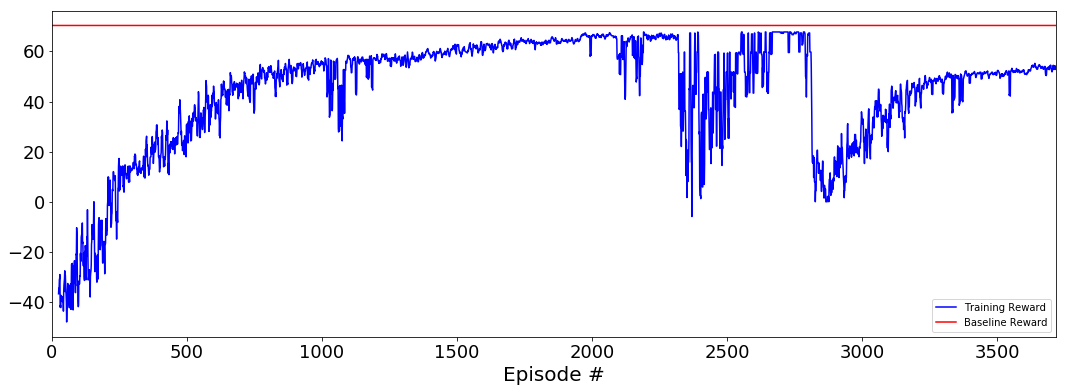

In [23]:
import pandas as pd
import matplotlib
%matplotlib inline

# csv_file has all the RL training metrics
csv_file = "{}/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv".format(tmp_dir)
csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = intermediate_folder_key + "/" + csv_file_name
wait_for_s3_object(s3_bucket, key, tmp_dir)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
x_axis = 'Episode #'
y_axis_rl = 'Training Reward'
y_axis_base = 'Baseline Reward'
df[y_axis_rl] = df[y_axis_rl].rolling(5).mean()
df[y_axis_base] = baseline_mean
y_axes = [y_axis_rl]
ax = df.plot(x=x_axis,y=[y_axis_rl,y_axis_base], figsize=(18,6), fontsize=18, legend=True, color=['b','r'])
fig = ax.get_figure()
ax.set_xlabel(x_axis,fontsize=20)
#ax.set_ylabel(y_axis,fontsize=20)
#fig.savefig('training_reward_vs_wall_clock_time.pdf')

#### Visualize the rendered gifs
The latest gif file found in the gifs directory is displayed. You can replace the tmp.gif file below to visualize other files generated.

Waiting for s3://sagemaker-us-east-1-273210948404/rl-tsp-easy-2019-06-27-04-17-16-301/output/intermediate/gifs...
Copied gifs files to /tmp/rl-tsp-easy-2019-06-27-04-17-16-301
GIFs found:
2019-06-27-04-19-37_episode-41_score--50.0.gif
2019-06-27-04-19-51_episode-116_score-4.540413723466152.gif
2019-06-27-04-19-58_episode-166_score-9.994800503949925.gif
2019-06-27-04-20-20_episode-316_score-15.82799911902157.gif
2019-06-27-04-20-59_episode-591_score-16.869665351642197.gif
2019-06-27-04-21-06_episode-641_score-18.239994660892535.gif
2019-06-27-04-21-15_episode-716_score-49.40641828270924.gif
2019-06-27-04-21-24_episode-791_score-52.50523163318144.gif
2019-06-27-04-21-40_episode-941_score-55.86407978801152.gif
2019-06-27-04-22-10_episode-1266_score-58.44839505981358.gif
2019-06-27-04-22-49_episode-1716_score-59.63221635903369.gif
2019-06-27-04-23-00_episode-1841_score-62.39914663571952.gif
2019-06-27-04-23-24_episode-2141_score-64.05264911367777.gif
2019-06-27-04-23-47_episode-2441_score-

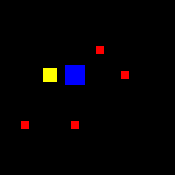

score-4


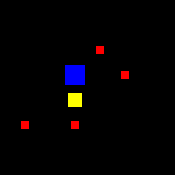

score-9


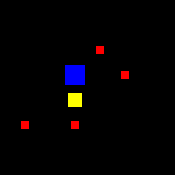

score-15


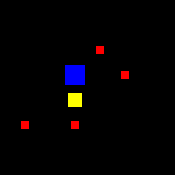

score-16


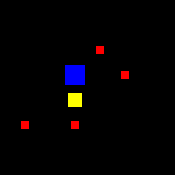

score-18


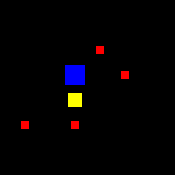

score-49


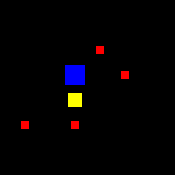

score-52


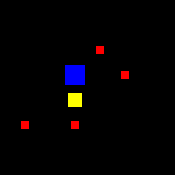

score-55


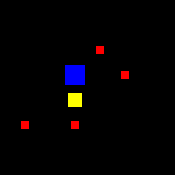

score-58


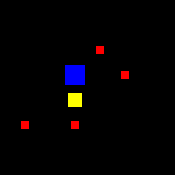

score-59


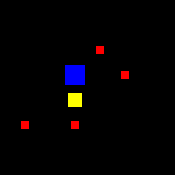

score-62


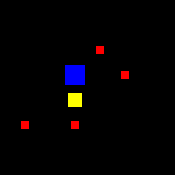

score-64


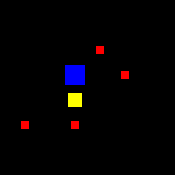

score-65


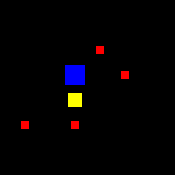

score-67


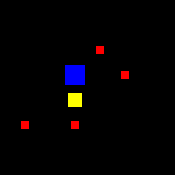

In [24]:
key = intermediate_folder_key + '/gifs'
wait_for_s3_object(s3_bucket, key, tmp_dir)    
print("Copied gifs files to {}".format(tmp_dir))

glob_pattern = os.path.join("{}/*.gif".format(tmp_dir))
gifs = [file for file in glob.iglob(glob_pattern, recursive=True)]
extract_episode = lambda string: int(re.search('.*episode-(\d*)_.*', string, re.IGNORECASE).group(1))
gifs.sort(key=extract_episode)
print("GIFs found:\n{}".format("\n".join([os.path.basename(gif) for gif in gifs])))    

# visualize a specific episode
#gif_index = -1 # since we want last gif
#gif_filepath = gifs[gif_index]
#gif_filename = os.path.basename(gif_filepath)
#print("Selected GIF: {}".format(gif_filename))
#os.system("mkdir -p ./src/tmp_render/ && cp {} ./src/tmp_render/{}.gif".format(gif_filepath, gif_filename))
#HTML('<img src="./src/tmp_render/{}.gif">'.format(gif_filename))

from IPython.display import Image
from IPython.display import display
for gif in gifs:
    print(gif.split('_')[2].split('.')[0])
    display(Image(filename=gif))